In [1]:
import os 
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os

# Analyse du dataset

Le dataset est composé d'images de radiographies thoraciques. Le dataset est déjà divisé en train, val et test. Les images sont classées en NORMAL et PNEUMONIA et sont en niveaux de gris.

Le problème est donc un problème de classification binaire. L'objectif est de prédire si une personne est atteinte de pneumonie ou non.

Nous commençons par définir des fonctions utilitaires pour parcourir et afficher les images. Ça nous sera utile pour analyser les données et comprendre les caractéristiques des images.

In [2]:
common_path = "./chest_Xray"
images_files = os.listdir(common_path)
subfolders = ["train","val","test"]
categories = ["NORMAL","PNEUMONIA"]

# Permet de parcourir les images, et pour chaque image, on applique une fonction de callback
# On peut optionnellement appeler une fonction de callback pour chaque dossier
def browse_imgs(img_callback, path_folder_callback = None, limit_size = None):
    for subfolder in subfolders:
        for category in categories:
            # pour avoir tous les chemins des 6 dossiers
            folder_path = os.path.join(common_path, subfolder, category)
            # liste de toutes les images
            images_files = os.listdir(folder_path)
            if path_folder_callback is not None:
                path_folder_callback(folder_path, images_files)
            array_limit = limit_size if limit_size is not None else len(images_files)
            #récupération de toutes les (ou des 'limit_size' premières) images du dossier.
            for file_name in images_files[:array_limit]:
                if not file_name.endswith(".jpeg"):
                    continue
                image_path = os.path.join(folder_path,file_name)
                img = cv2.imread(image_path,cv2.IMREAD_GRAYSCALE)
                img_callback(img, category, subfolder)
                
                
def display_imgs(imgs, titles = [], plot_size = (1,1), figsize = (10,8)):
    fig = plt.figure(figsize=figsize)
    index = 0
    for image, title in zip(imgs, titles):
        index += 1
        ax = fig.add_subplot(plot_size[0], plot_size[1], index) 
        ax.imshow(image, cmap="gray")
        ax.axis("off")
        if titles is not None:
            ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [3]:
folders_infos = {}
current_folder = None
def get_folders_infos_callback(folder_path, images_files):
    global folders_infos, current_folder
    folders_infos[folder_path] = []
    current_folder = folder_path
    
def add_imgs_size_to_folders_infos_callback(img, category, subfolder):
    folders_infos[current_folder].append(img.shape)

browse_imgs(add_imgs_size_to_folders_infos_callback, get_folders_infos_callback, limit_size=5)

for folder_path, imgs_sizes in folders_infos.items():
    print("tailles des premières images du dossier {} : {}".format(folder_path, imgs_sizes) )

tailles des premières images du dossier ./chest_Xray\train\NORMAL : [(1858, 2090), (1152, 1422), (1434, 1810), (1279, 1618), (1125, 1600)]
tailles des premières images du dossier ./chest_Xray\train\PNEUMONIA : [(760, 1152), (768, 1072), (863, 1244), (940, 1242), (1280, 1488)]
tailles des premières images du dossier ./chest_Xray\val\NORMAL : [(1416, 1776), (1040, 1272), (1416, 1736), (928, 1288), (1104, 1240)]
tailles des premières images du dossier ./chest_Xray\val\PNEUMONIA : [(592, 968), (712, 1072), (664, 1152), (944, 1416), (864, 1256)]
tailles des premières images du dossier ./chest_Xray\test\NORMAL : [(1317, 1857), (1509, 2111), (1837, 2031), (1326, 1663), (1818, 2053)]
tailles des premières images du dossier ./chest_Xray\test\PNEUMONIA : [(762, 1106), (680, 1024), (624, 1128), (552, 904), (536, 880)]


On constate que les radios sont de tailles différentes. L'uniformisation des données est une étape importante du prétraitement des données. Il faudra donc les redimensionner pour les passer en entrée d'un modèle de machine learning.

Analysons plus en détail l'hétérogénéité du dataset.

In [4]:
smallest_img = None
largest_img = None

def search_size_callback(img, category=None, subfolder=None):
    global smallest_img, largest_img
    largest_img_size = largest_img.shape if largest_img is not None else None
    smallest_img_size = smallest_img.shape if smallest_img is not None else None
    img_size = img.shape
    if largest_img_size is None or img_size > largest_img_size:
        largest_img = img
    if smallest_img_size is None or img_size < smallest_img_size:
        smallest_img = img

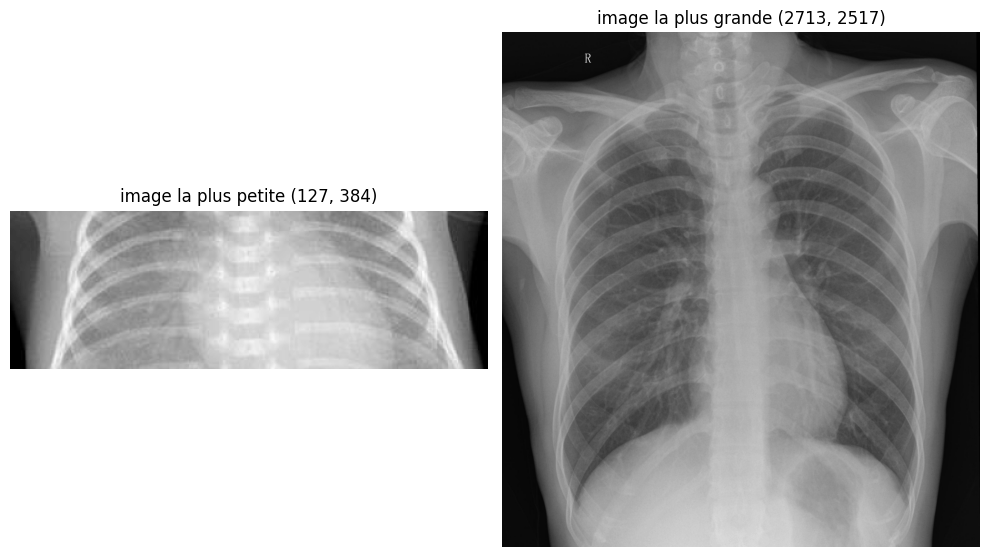

In [5]:
browse_imgs(search_size_callback)               
                    
display_imgs([smallest_img, largest_img], ["image la plus petite {}".format(smallest_img.shape), "image la plus grande {}".format(largest_img.shape)], (1,2))

Cet exemple illustre la grande hétérogénéité des tailles des images. On remarque notamment que certaines images sont inexploitables, à l'image de la plus petite qui rogne une partie de la radio.

Nous allons essayer de sélectionner les images en fonction de leurs ratios. L'objectif premier est de filtrer les images plus larges que longues, qui ne correspondent pas à un format radio.

In [7]:
def img_is_in_ratio(img, min_ratio = 1, max_ratio = 1.5):
    height, width = img.shape
    ratio = width / height
    if min_ratio <= ratio <= max_ratio:
        return True
    else:
        return False

In [8]:
nb_imgs_before_sort = 0
# On stock les images de façon unique dans un tableau pour économiser la RAM
sorted_images = []
# On stock les index des images dans sorted_images pour chaque ratio
sorted_imgs_indexes = {1.1:[], 1.2:[], 1.3:[], 1.5:[], 1.6:[], 2:[]}

# Distribution des categories par ratio {ratio: {test|train|val} = (nb_normal, nb_pneumonia)}
distribution = {1.1:{}, 1.2:{}, 1.3:{}, 1.5:{}, 1.6:{}, 2:{}}

def sort_img_callback(img, category, subfolder):
    global nb_imgs_before_sort, sorted_imgs_indexes, sorted_images
    nb_imgs_before_sort += 1
    for ratio_max, img_array in sorted_imgs_indexes.items():
        if subfolder not in distribution[ratio_max]:
            distribution[ratio_max][subfolder] = (0,0)
            
        if img_is_in_ratio(img, max_ratio=ratio_max):

            if category == "NORMAL":
                distribution[ratio_max][subfolder] = (distribution[ratio_max][subfolder][0]+1, distribution[ratio_max][subfolder][1])
            else:
                distribution[ratio_max][subfolder] = (distribution[ratio_max][subfolder][0], distribution[ratio_max][subfolder][1]+1)

            try:
                img_index = sorted_images.index(img)
                img_array.append(img_index)
            except ValueError:
                sorted_images.append(img)
                img_array.append(len(sorted_images)-1)
            
browse_imgs(sort_img_callback)

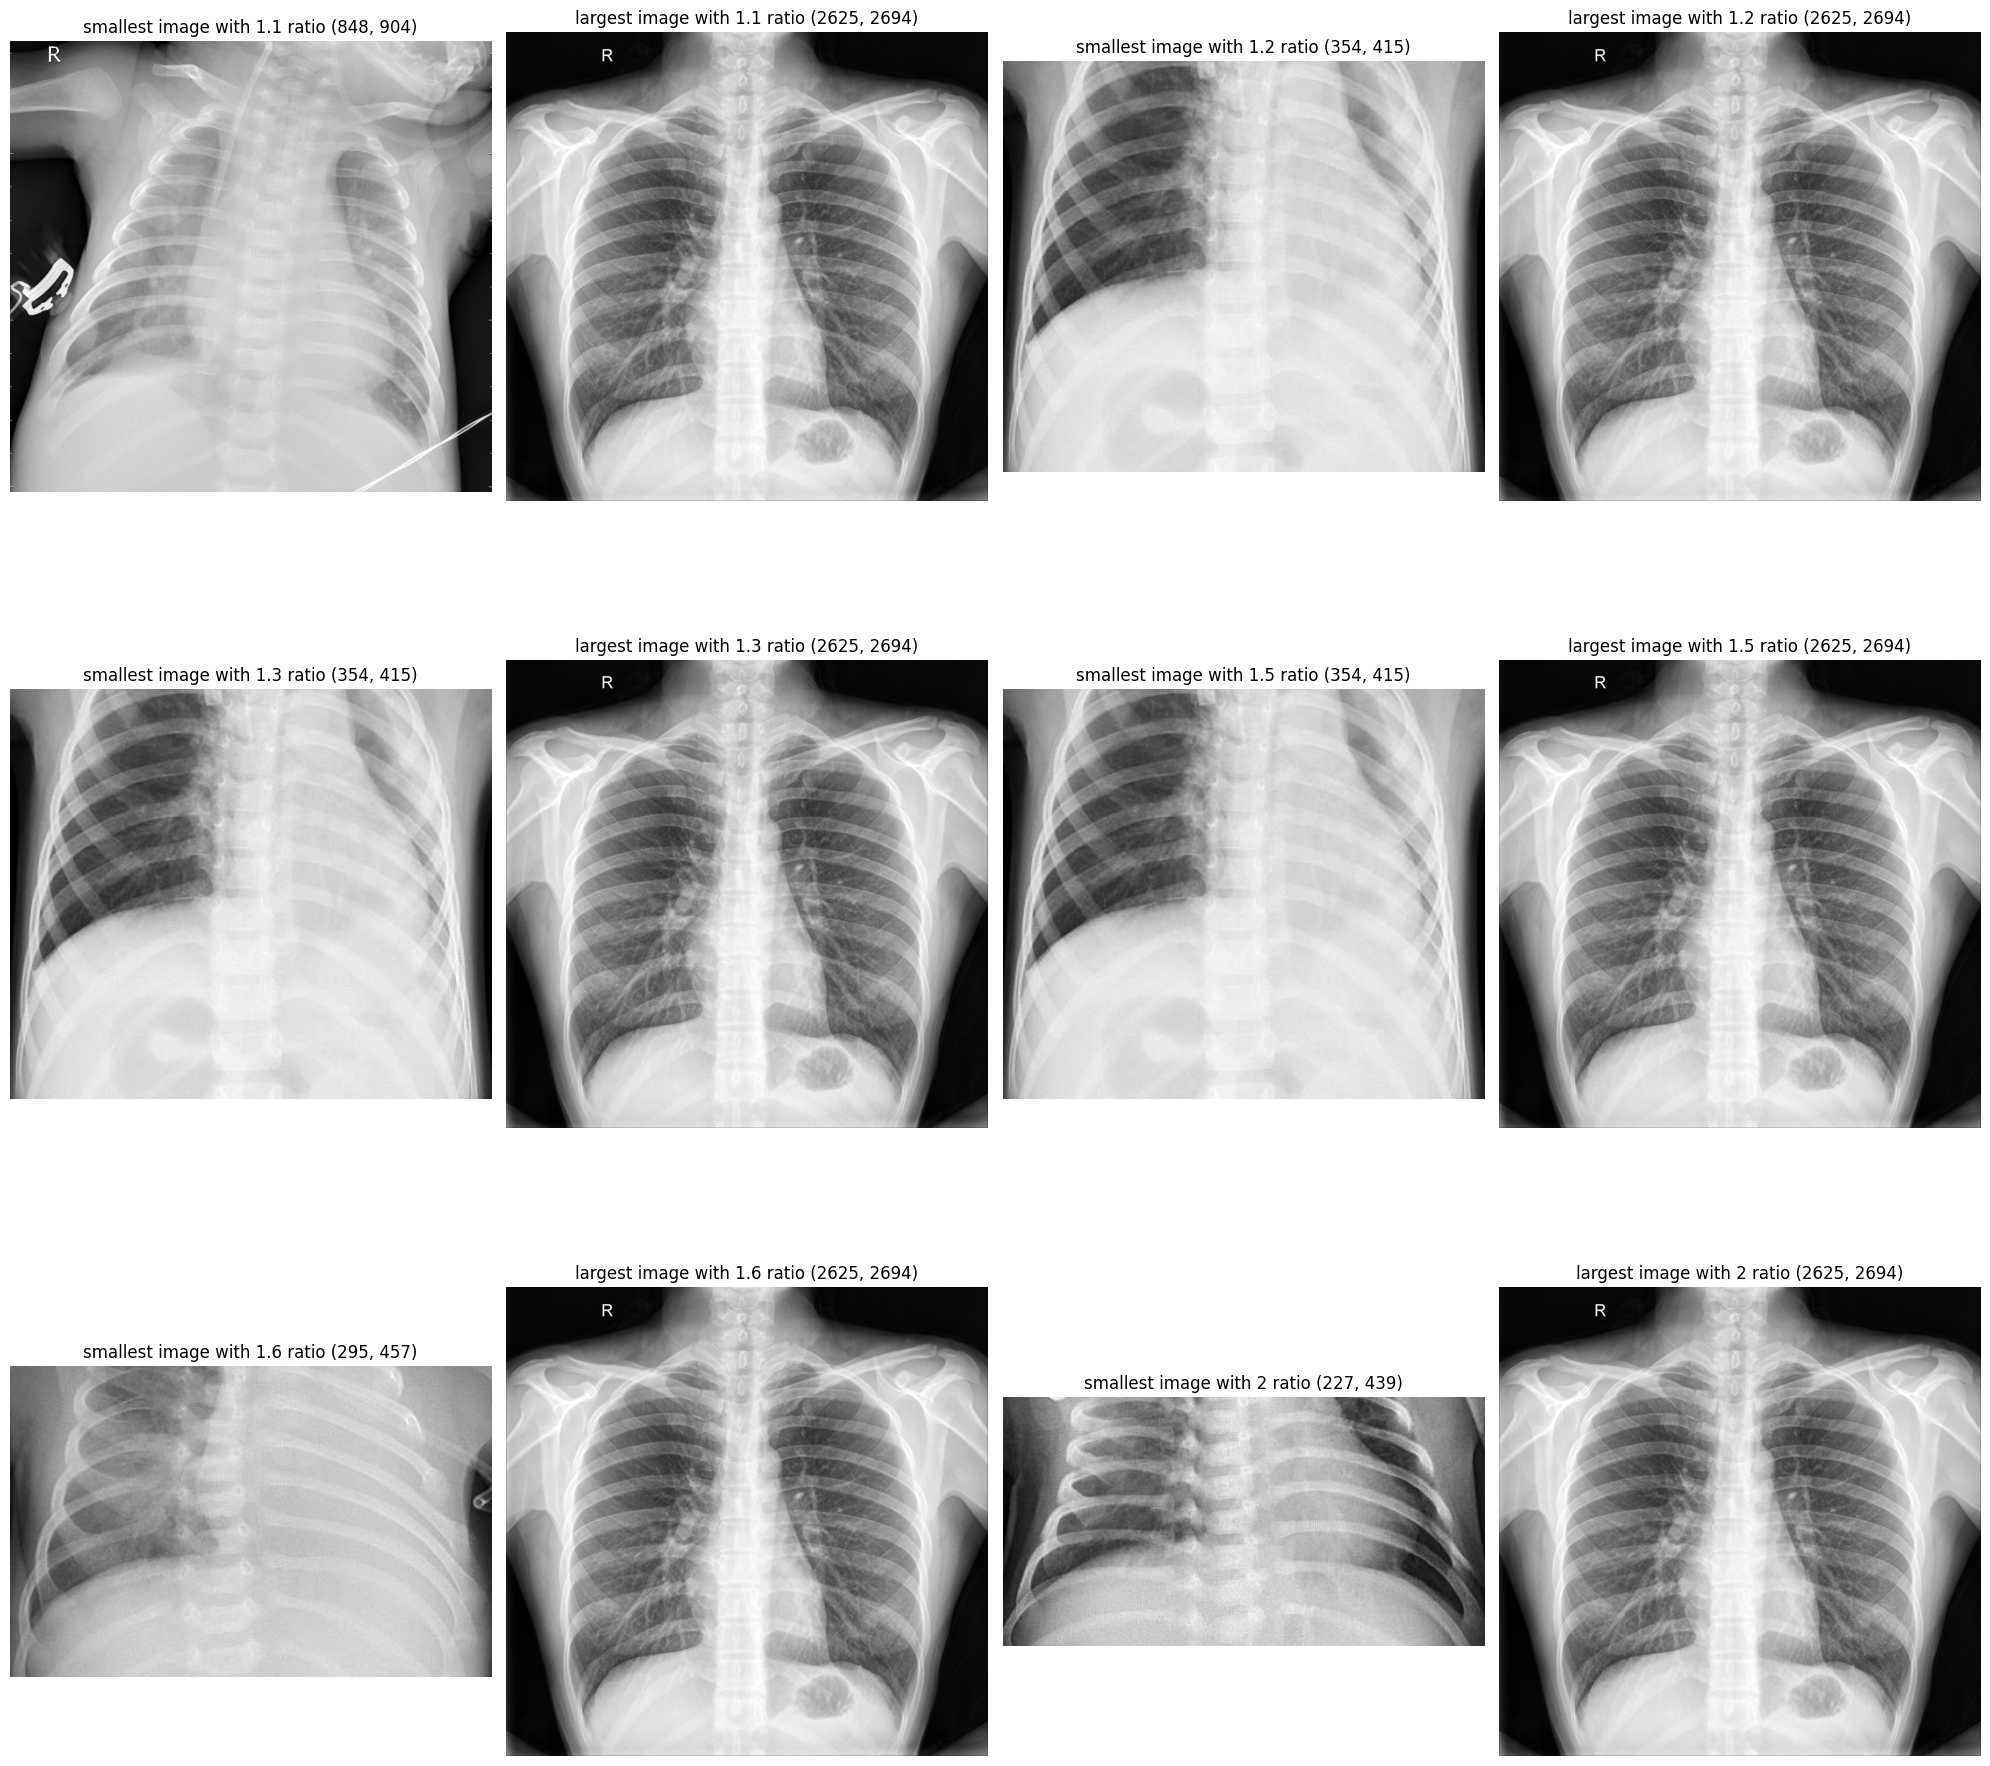

In [9]:
# Display smallest and largest image for each ratio
smallest_img = None
largest_img = None

imgs_to_display = []
titles = []
for ratio_max, indexes in sorted_imgs_indexes.items():
    for index in indexes:
        search_size_callback(sorted_images[index])
    imgs_to_display.append(smallest_img)
    titles.append("smallest image with {} ratio {}".format(ratio_max, smallest_img.shape))
    imgs_to_display.append(largest_img)
    titles.append("largest image with {} ratio {}".format(ratio_max, largest_img.shape))

display_imgs(imgs_to_display, titles, (int(len(sorted_imgs_indexes) / 2), 4), figsize=(20, 20))

On constate que l'image la plus grande est toujours la même, et que son format est idéal avec un ration proche de 1 (un carré). On remarque également que plus le ratio max est élevé, plus les petites images sont déformées et inexploitables.

Cet exemple n'est cependant pas très pertinent, pour confirmer cette hypothèse nous allons plutôt analyser des images ayant les ratios extrême de chaque tranche.

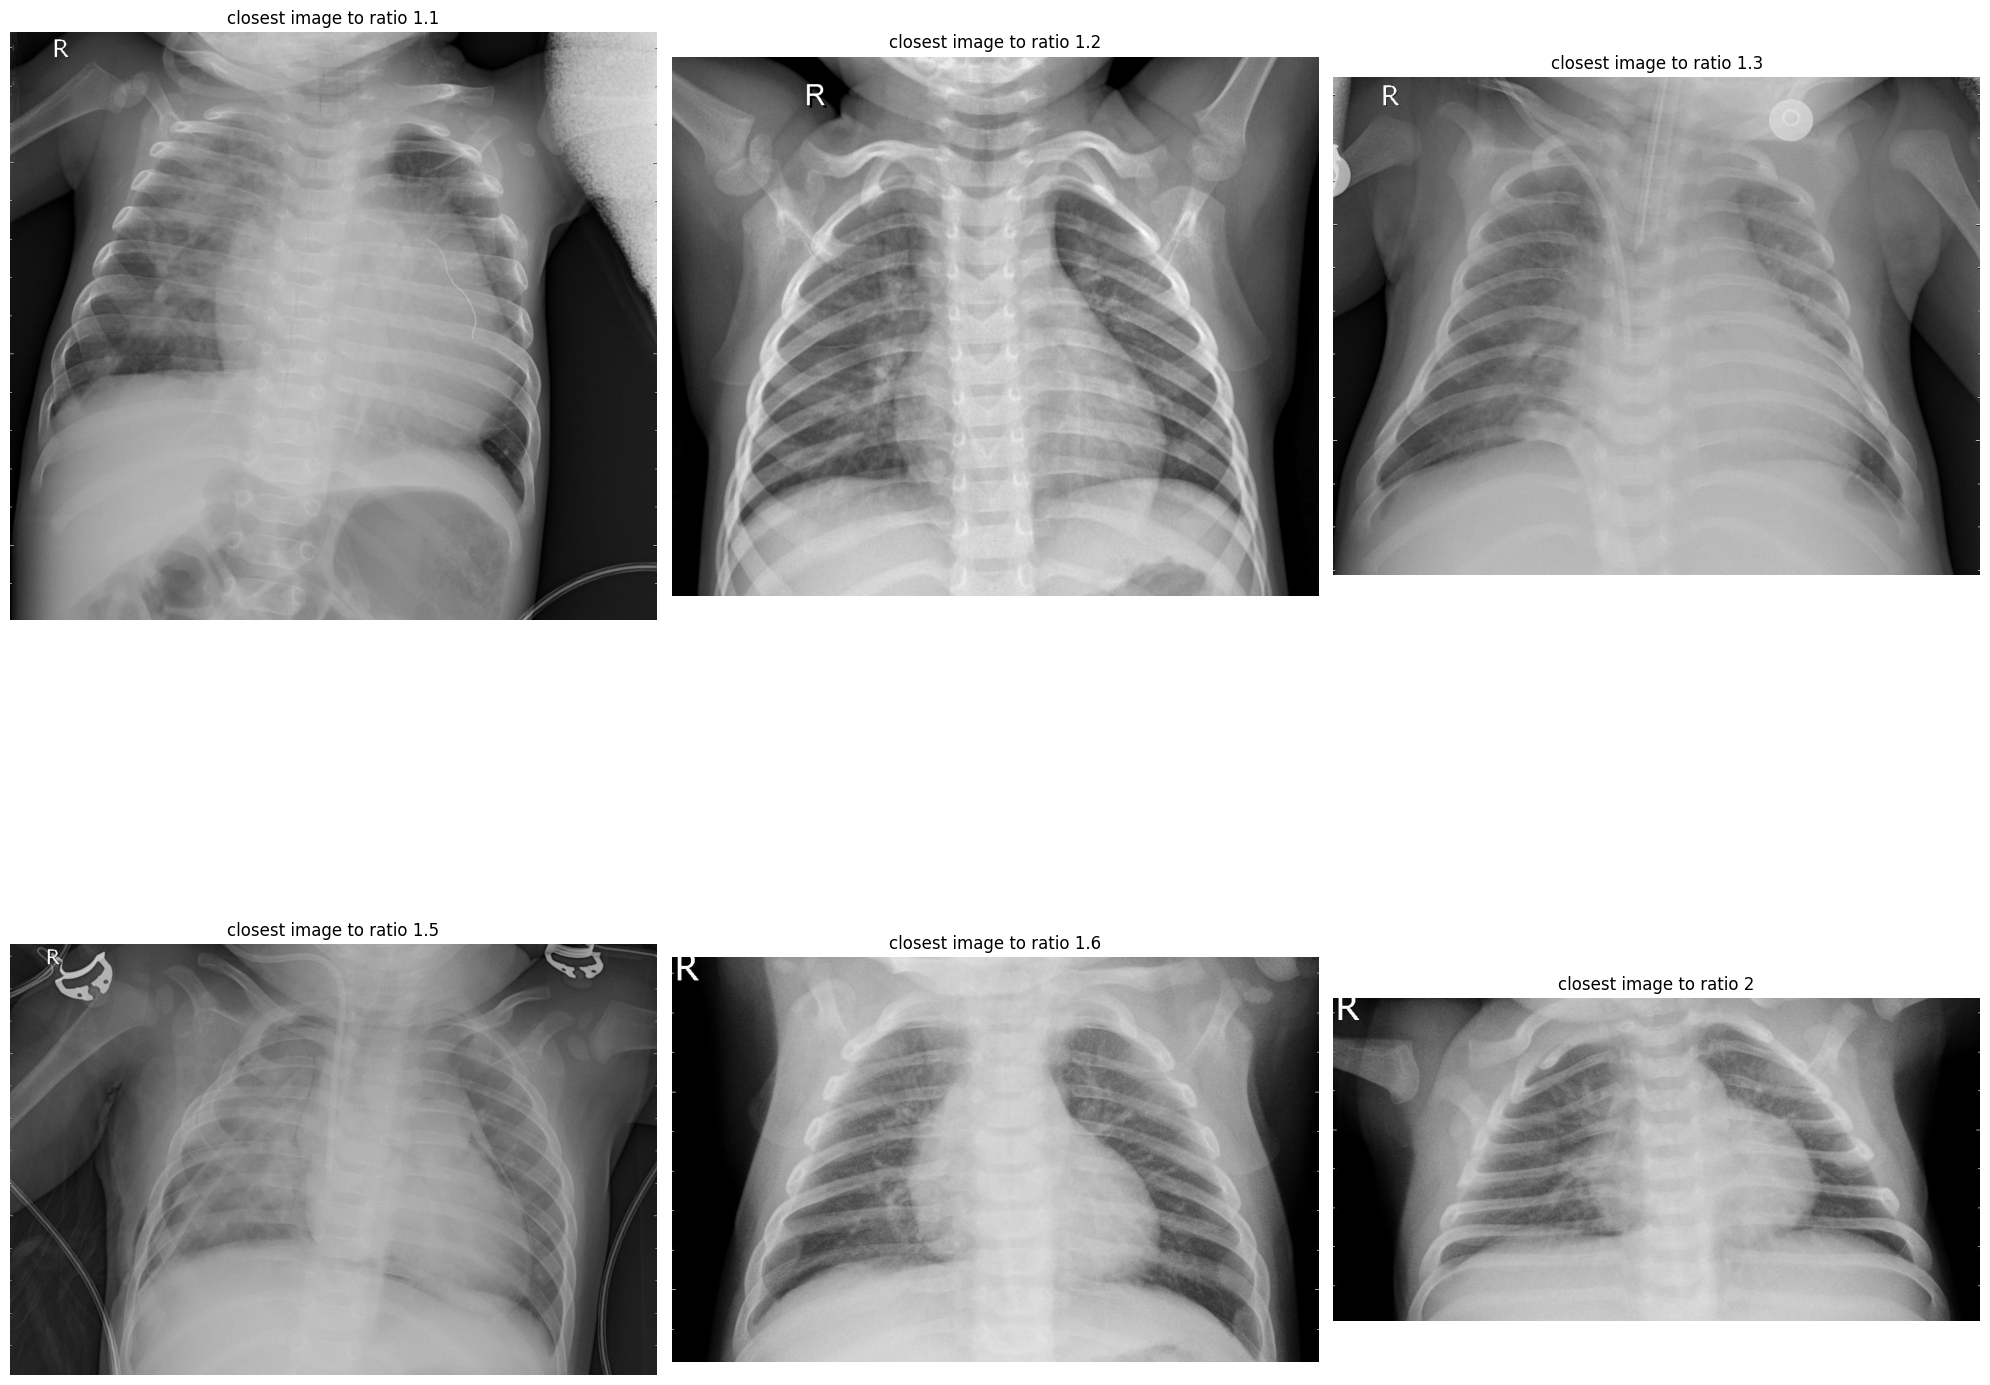

In [10]:
# Display image closest to ratios
ratios = [1.1, 1.2, 1.3, 1.5, 1.6, 2]
closest_imgs = []

for ratio in ratios:
    closest_img = None
    closest_diff = None
    for index in sorted_imgs_indexes[ratio]:
        img = sorted_images[index]
        img_ratio = img.shape[1] / img.shape[0]
        diff = abs(img_ratio - ratio)
        if closest_diff is None or diff < closest_diff:
            closest_diff = diff
            closest_img = img
    closest_imgs.append(closest_img)

display_imgs(closest_imgs, ["closest image to ratio {}".format(ratio) for ratio in ratios], (2, 3), figsize=(20, 20))

Cet exemple confirme clairement l'hypothèse précédente. Plus le ratio est élevé, plus l'image est étiré et rogné, donc moins elle est exploitable.

L'idéal serait donc de garder uniquement les images ayant un ratio proche de 1. Il faut cependant trouver un compromis entre la qualité des images et la quantité d'images gardées.

834314
(2625, 2694)


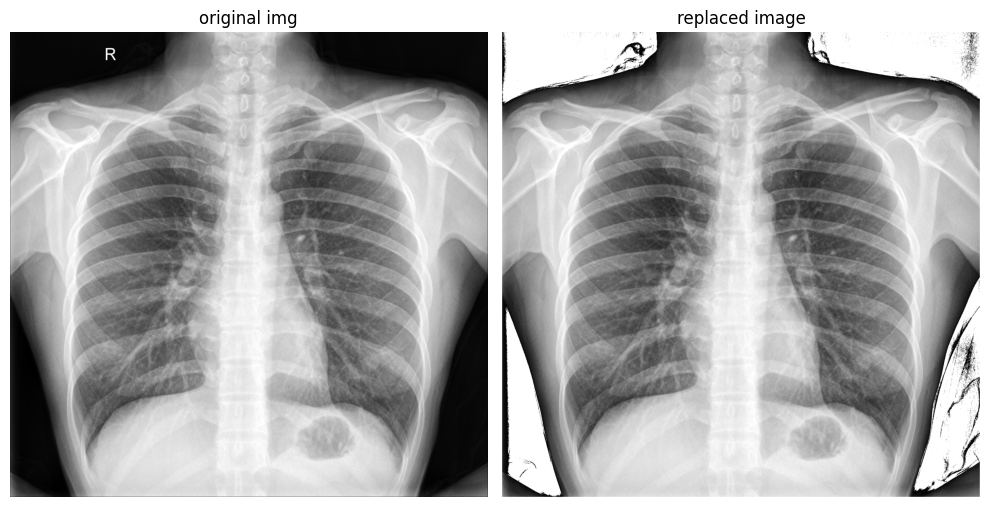

In [11]:
img = imgs_to_display[1]
grey_scale_limit = 10
print(np.sum(img <= grey_scale_limit))
print(img.shape)
new_img = img.copy()
new_img[new_img <= grey_scale_limit] = 255
display_imgs([img, new_img], titles=["original img", "replaced image"], plot_size=(1, 2))

In [12]:
thresholds = {5:[], 10:[], 15:[], 20:[]}
def keep_enough_black_pixel(img, category, subfolder):
    height, width = img.shape
    percent = (np.sum(img <= grey_scale_limit)*100)/(width*height)
    for threshold, imgs_array in thresholds.items():
        if percent >= threshold:
            imgs_array.append(img)
        

browse_imgs(keep_enough_black_pixel)

In [13]:
for threshold, imgs_array in thresholds.items():
    print("Images with more than {}% of black pixels : {}".format(threshold, len(imgs_array)))
    

Images with more than 5% of black pixels : 3178
Images with more than 10% of black pixels : 1717
Images with more than 15% of black pixels : 562
Images with more than 20% of black pixels : 127


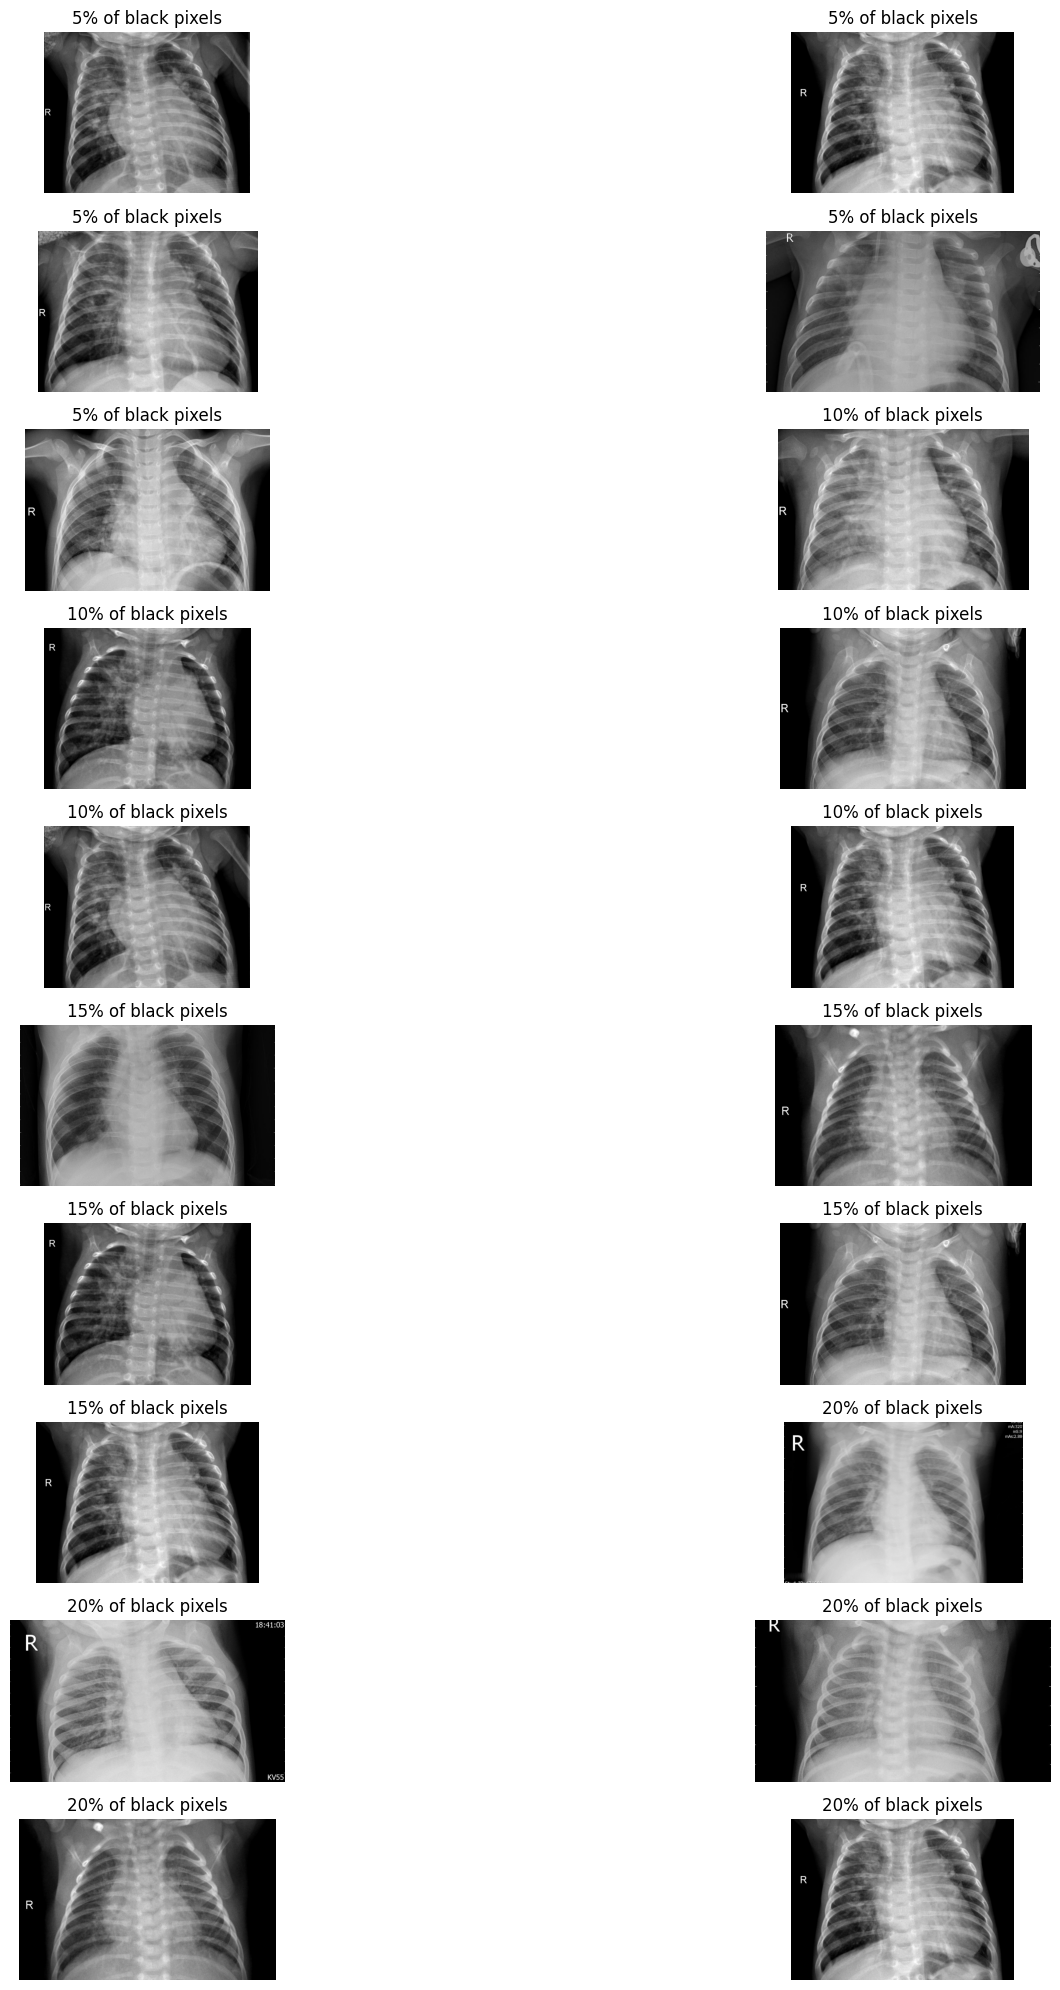

In [14]:
imgs_to_display = []
titles = []
for threshold, imgs_array in thresholds.items():
    nb_imgs = len(imgs_array)
    imgs_to_display += imgs_array[nb_imgs - 5:]
    titles += ["{}% of black pixels".format(threshold)]*5

display_imgs(imgs_to_display, titles, (int(len(imgs_to_display) / 2), 2), figsize=(20, 20))

In [15]:
nb_imgs = 0;
for img in thresholds[5]:
    if img_is_in_ratio(img, max_ratio=1.6):
        nb_imgs += 1

print("Nombre d'images avec plus de 5% de pixels noirs et un ratio de 1.6 : ", nb_imgs)


Nombre d'images avec plus de 5% de pixels noirs et un ratio de 1.6 :  2502


In [16]:
print("Nombre d'images avant le prétraitement :", nb_imgs_before_sort)
for ratio_t, indexes_array in sorted_imgs_indexes.items():
    print("Nombre d'images après le prétraitement pour un ratio {} : {}".format(ratio_t, len(indexes_array)))

Nombre d'images avant le prétraitement : 5856
Nombre d'images après le prétraitement pour un ratio 1.1 : 238
Nombre d'images après le prétraitement pour un ratio 1.2 : 849
Nombre d'images après le prétraitement pour un ratio 1.3 : 1757
Nombre d'images après le prétraitement pour un ratio 1.5 : 3672
Nombre d'images après le prétraitement pour un ratio 1.6 : 4431
Nombre d'images après le prétraitement pour un ratio 2 : 5668


Malheureusement, la taille du dataset diminue très vite. Il nous faudra trouver la taille idéal du dataset et étudier l'impact des images au mauvais ratio sur les performances des modèles pour trouver le meilleur compromis.

Affichage du nombre d'image par classes

Distribution for a ratio of 1.1 :
For the folder train : 169 normal images and 53 pneumonia images
For the folder val : 0 normal images and 0 pneumonia images
For the folder test : 13 normal images and 3 pneumonia images


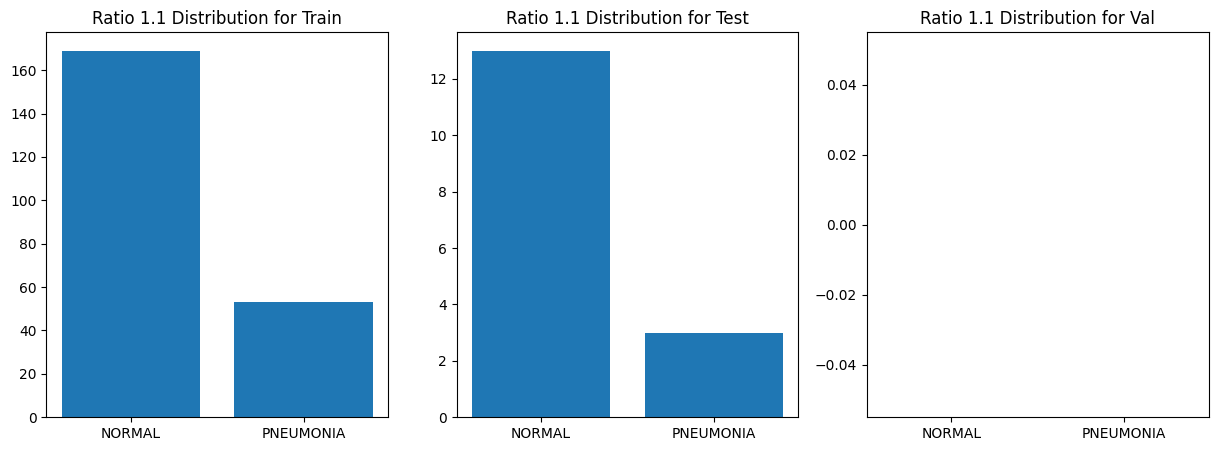

Distribution for a ratio of 1.2 :
For the folder train : 531 normal images and 254 pneumonia images
For the folder val : 1 normal images and 0 pneumonia images
For the folder test : 50 normal images and 13 pneumonia images


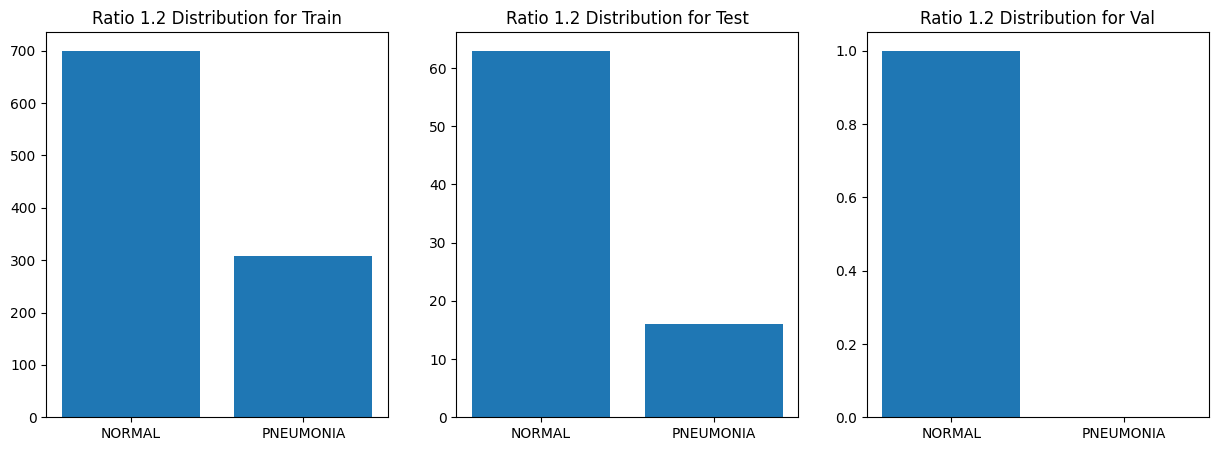

Distribution for a ratio of 1.3 :
For the folder train : 926 normal images and 673 pneumonia images
For the folder val : 6 normal images and 1 pneumonia images
For the folder test : 94 normal images and 57 pneumonia images


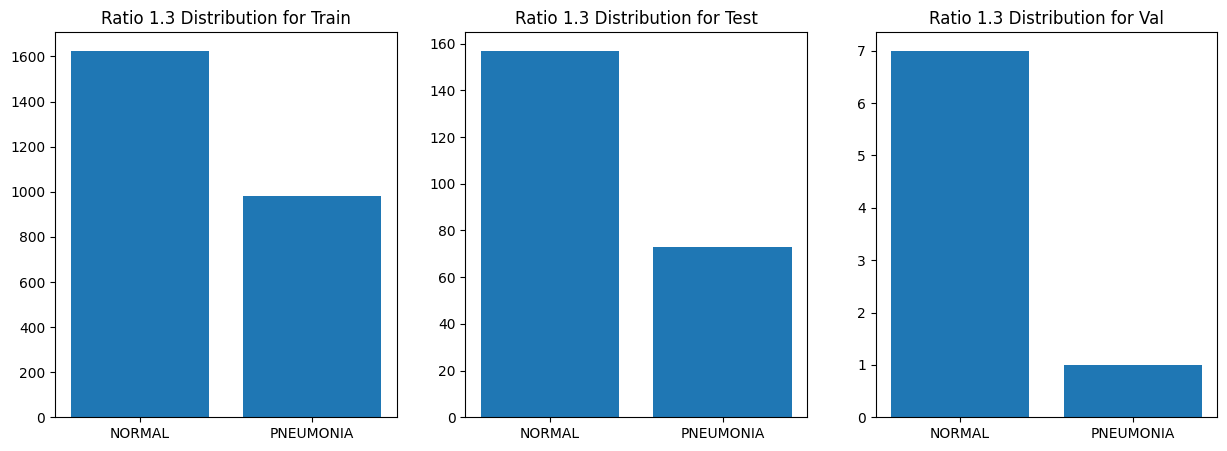

Distribution for a ratio of 1.5 :
For the folder train : 1268 normal images and 2035 pneumonia images
For the folder val : 8 normal images and 4 pneumonia images
For the folder test : 167 normal images and 190 pneumonia images


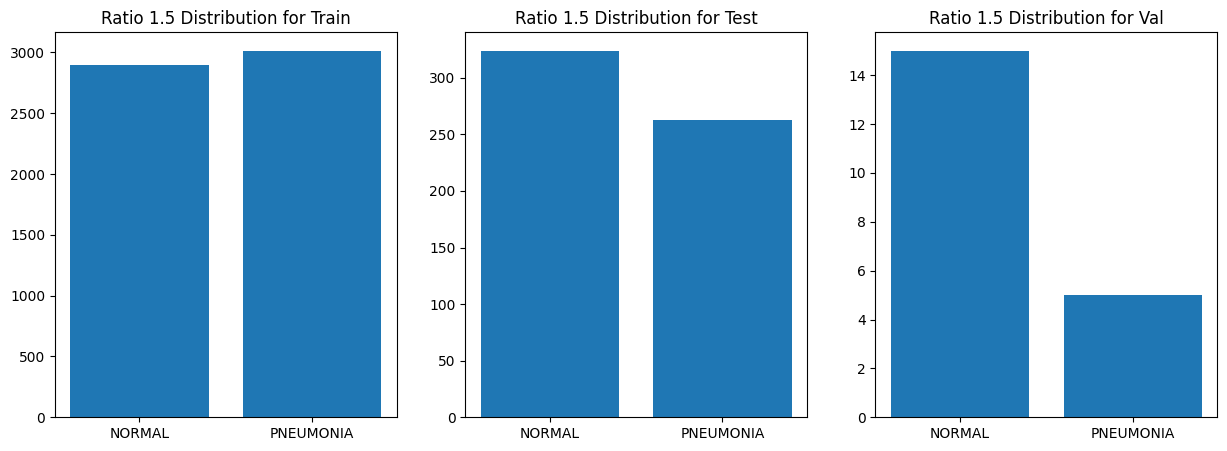

Distribution for a ratio of 1.6 :
For the folder train : 1294 normal images and 2661 pneumonia images
For the folder val : 8 normal images and 6 pneumonia images
For the folder test : 197 normal images and 265 pneumonia images


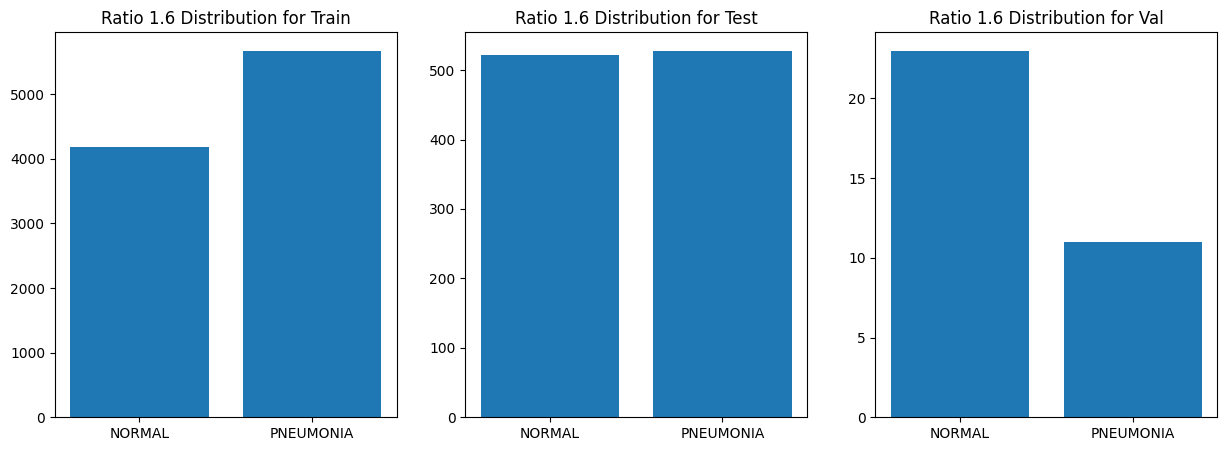

Distribution for a ratio of 2 :
For the folder train : 1298 normal images and 3744 pneumonia images
For the folder val : 8 normal images and 8 pneumonia images
For the folder test : 228 normal images and 382 pneumonia images


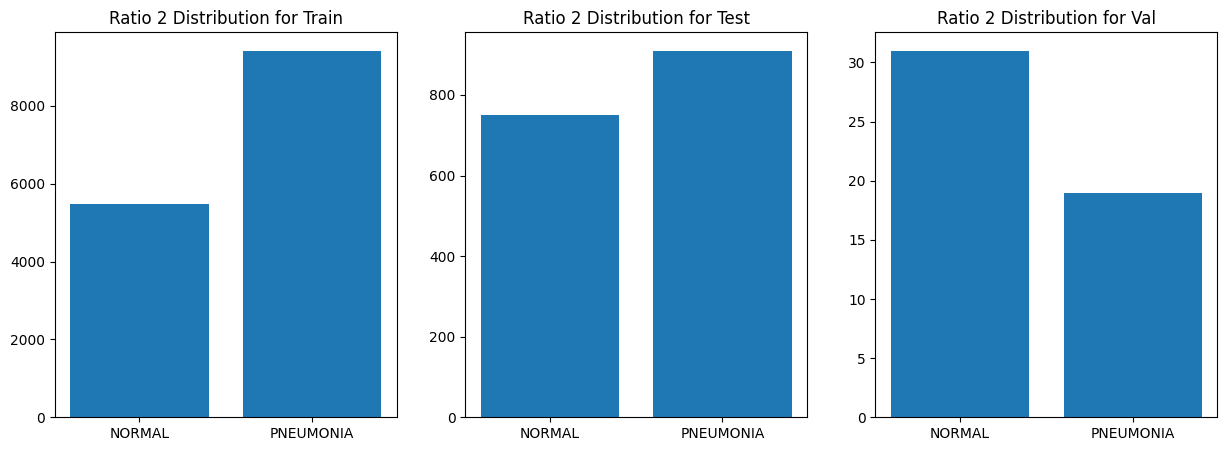

In [17]:
def display_distribution_per_ratios():
    subfolders = {"train": (0,0), "test": (0,0), "val": (0,0)}

    for ratio_key, ratio_items in distribution.items():
        print(f"Distribution for a ratio of {ratio_key} :")
        for subfolder, (nb_normal, nb_pneumonia) in ratio_items.items():
            print(f"For the folder {subfolder} : {nb_normal} normal images and {nb_pneumonia} pneumonia images")
            subfolders[subfolder] = (subfolders[subfolder][0] + nb_normal, subfolders[subfolder][1] + nb_pneumonia)
        print("\n")

        # Plot par ratio 
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        for i, (subfolder, counts) in enumerate(subfolders.items()):
            ax[i].bar(["NORMAL", "PNEUMONIA"], counts)
            ax[i].set_title(f"Ratio {ratio_key} Distribution for {subfolder.capitalize()}")
        plt.show()

display_distribution_per_ratios()